In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), ".."))

In [3]:
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [5]:

from certainty import EventSentence, load_file, convert_events, EventType, bootstrap_metrics

In [6]:
sns.set_theme(rc={'figure.figsize':(11.7,4.27)})

In [7]:
bio_df = pd.read_csv('../results/bio_factuality_metrics.csv')

In [8]:
bio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Name                                5 non-null      object 
 1   Created                             5 non-null      object 
 2   Runtime                             5 non-null      int64  
 3   State                               5 non-null      object 
 4   model                               5 non-null      object 
 5   epochs                              5 non-null      int64  
 6   train/learning_rate                 5 non-null      float64
 7   eval/event_f1                       5 non-null      float64
 8   eval/event_precision                5 non-null      float64
 9   eval/event_recall                   5 non-null      float64
 10  eval/discovered_asserted_f1         5 non-null      float64
 11  eval/discovered_asserted_precision  5 non-null   

In [48]:
event_detection_stats_df = bio_df.describe().loc[['mean', 'std']]

In [49]:
event_detection_stats_df

,Runtime,epochs,train/learning_rate,eval/event_f1,eval/event_precision,eval/event_recall,eval/discovered_asserted_f1,eval/discovered_asserted_precision,eval/discovered_asserted_recall,eval/discovered_false_asserted,...,eval/all_asserted_precision,eval/all_asserted_recall,eval/all_false_negative_other,eval/all_false_positive_other,eval/all_other_f1,eval/all_other_precision,eval/all_other_recall,eval/all_true_positive_asserted,eval/all_true_positive_other,eval/true_positives
mean,953.600000,20.0,0.00005,0.791005,0.781621,0.806048,0.891472,0.880338,0.904377,36.600000,...,0.692125,0.749438,72.000000,59.600000,0.504824,0.545803,0.485714,266.800000,68.000000,399.800000
std,56.336489,0.0,0.00000,0.016115,0.045079,0.060692,0.006860,0.022242,0.035024,8.848729,...,0.034570,0.045873,13.601471,24.275502,0.030942,0.054950,0.097153,16.330952,13.601471,30.103156


In [50]:
selected_counts = ['eval/false_negatives', 
                   'eval/false_positives', 
                   'eval/true_positives',
                  'eval/discovered_true_asserted',
                  'eval/discovered_true_other',
                  'eval/discovered_false_asserted',
                  'eval/discovered_false_other',
                  'eval/all_false_negative_asserted',
                  'eval/all_false_negative_other',
                  'eval/all_false_positive_asserted',
                  'eval/all_false_positive_other']

counts_columns = {'eval/false_negatives': 'Undiscovered events (false negatives)', 
                   'eval/false_positives': 'Spurious events (false positives)', 
                   'eval/true_positives': 'Discovered events (true positives)',
                  'eval/discovered_true_asserted': 'Discovered Asserted events (true Asserted)',
                  'eval/discovered_true_other': 'Discovered Other events (true Other)',
                  'eval/discovered_false_asserted': 'Discovered False Asserted events (false Asserted)',
                  'eval/discovered_false_other': 'Discovered False Other events (false Other)',
                  'eval/all_false_negative_asserted': 'All undiscovered Other events (false negative Asserted)',
                  'eval/all_false_negative_other': 'All undiscovered Asserted events (false negative Other)',
                  'eval/all_false_positive_asserted': 'All spurious Asserted events (false positive Asserted)',
                  'eval/all_false_positive_other': 'All spurious Other events (false positive Other)'}

In [51]:
selected_stats = ['eval/event_f1', 
                  'eval/event_precision', 
                  'eval/event_recall', 
                  'eval/discovered_asserted_f1', 
                  'eval/discovered_other_f1',
                  'eval/discovered_asserted_precision', 
                  'eval/discovered_other_precision',
                  'eval/discovered_asserted_recall', 
                  'eval/discovered_other_recall', 
                  'eval/all_asserted_f1',
                  'eval/all_other_f1',
                  'eval/all_asserted_precision',
                    'eval/all_other_precision',
                 'eval/all_asserted_recall',
                 'eval/all_other_recall']

In [52]:
event_detection_counts_df = event_detection_stats_df[selected_counts]

In [53]:
event_detection_stats_df = event_detection_stats_df[selected_stats]

In [55]:
event_detection_counts_df

,eval/false_negatives,eval/false_positives,eval/true_positives,eval/discovered_true_asserted,eval/discovered_true_other,eval/discovered_false_asserted,eval/discovered_false_other,eval/all_false_negative_asserted,eval/all_false_negative_other,eval/all_false_positive_asserted,eval/all_false_positive_other
mean,96.200000,114.600000,399.800000,266.800000,68.000000,36.600000,28.400000,89.200000,72.000000,120.000000,59.600000
std,30.103156,36.882245,30.103156,16.330952,13.601471,8.848729,11.081516,16.330952,13.601471,22.978251,24.275502


In [54]:
event_detection_stats_df

,eval/event_f1,eval/event_precision,eval/event_recall,eval/discovered_asserted_f1,eval/discovered_other_f1,eval/discovered_asserted_precision,eval/discovered_other_precision,eval/discovered_asserted_recall,eval/discovered_other_recall,eval/all_asserted_f1,eval/all_other_f1,eval/all_asserted_precision,eval/all_other_precision,eval/all_asserted_recall,eval/all_other_recall
mean,0.791005,0.781621,0.806048,0.891472,0.673344,0.880338,0.712914,0.904377,0.647917,0.718174,0.504824,0.692125,0.545803,0.749438,0.485714
std,0.016115,0.045079,0.060692,0.006860,0.028868,0.022242,0.050318,0.035024,0.086936,0.016526,0.030942,0.034570,0.054950,0.045873,0.097153


In [40]:
columns = {"eval/event_f1": "f1 Event detection", 
           "eval/event_precision": "Precision Event detection", 
           "eval/event_recall": "Recall Event detection",
          'eval/discovered_asserted_f1': "Discovered Asserted F1", 
                  'eval/discovered_other_f1': "Discovered Other F1",
                  'eval/discovered_asserted_precision': "Discovered Asserted Precision", 
                  'eval/discovered_other_precision': "Discovered Other Precision",
                  'eval/discovered_asserted_recall': "Discovered Asserted Recall", 
                  'eval/discovered_other_recall': "Discovered Other Recall", 
                  'eval/all_asserted_f1': "All Asserted F1",
                 'eval/all_other_f1': "All Other F1",
                  'eval/all_asserted_precision': "All Asserted Precision",
                 'eval/all_other_precision': "All Other Precision",
                 'eval/all_asserted_recall': "All Asserted Recall",
                 'eval/all_other_recall': "All Other Recall"}

event_detection_stats_df=event_detection_stats_df.rename(columns=columns).T

In [57]:
event_detection_counts_df=event_detection_counts_df.rename(columns=counts_columns).T

In [41]:
ed_df = event_detection_stats_df

In [42]:
ed_df

,mean,std
f1 Event detection,0.791005,0.016115
Precision Event detection,0.781621,0.045079
Recall Event detection,0.806048,0.060692
Discovered Asserted F1,0.891472,0.006860
Discovered Other F1,0.673344,0.028868
Discovered Asserted Precision,0.880338,0.022242
Discovered Other Precision,0.712914,0.050318
Discovered Asserted Recall,0.904377,0.035024
Discovered Other Recall,0.647917,0.086936
All Asserted F1,0.718174,0.016526


In [58]:
event_detection_counts_df

,mean,std
Undiscovered events (false negatives),96.2,30.103156
Spurious events (false positives),114.6,36.882245
Discovered events (true positives),399.8,30.103156
Discovered Asserted events (true Asserted),266.8,16.330952
Discovered Other events (true Other),68.0,13.601471
Discovered False Asserted events (false Asserted),36.6,8.848729
Discovered False Other events (false Other),28.4,11.081516
All undiscovered Other events (false negative Asserted),89.2,16.330952
All undiscovered Asserted events (false negative Other),72.0,13.601471
All spurious Asserted events (false positive Asserted),120.0,22.978251


In [59]:
ec_df = event_detection_counts_df

In [62]:
ec_df['mean_numeric'] = pd.to_numeric(ec_df['mean'], errors='coerce')
ec_df['std_numeric'] = pd.to_numeric(ec_df['std'], errors='coerce')

ec_df['mean_std'] = ec_df.apply(
    lambda row: f"{row['mean_numeric']:.3f} ± {row['std_numeric']:.3f}" 
    if pd.notna(row['mean_numeric']) and pd.notna(row['std_numeric'])
    else f"{row['mean']} ± {row['std']}",  # Keep original format for Runtime
    axis=1
)

In [63]:
ed_df['mean_numeric'] = pd.to_numeric(ed_df['mean'], errors='coerce')
ed_df['std_numeric'] = pd.to_numeric(ed_df['std'], errors='coerce')

ed_df['mean_std'] = ed_df.apply(
    lambda row: f"{row['mean_numeric']:.3f} ± {row['std_numeric']:.3f}" 
    if pd.notna(row['mean_numeric']) and pd.notna(row['std_numeric'])
    else f"{row['mean']} ± {row['std']}",  # Keep original format for Runtime
    axis=1
)



In [44]:
metrics = ed_df[['mean_std']]

In [45]:
metrics

,mean_std
f1 Event detection,0.791 ± 0.016
Precision Event detection,0.782 ± 0.045
Recall Event detection,0.806 ± 0.061
Discovered Asserted F1,0.891 ± 0.007
Discovered Other F1,0.673 ± 0.029
Discovered Asserted Precision,0.880 ± 0.022
Discovered Other Precision,0.713 ± 0.050
Discovered Asserted Recall,0.904 ± 0.035
Discovered Other Recall,0.648 ± 0.087
All Asserted F1,0.718 ± 0.017


In [46]:
print(metrics[['mean_std']].to_latex(bold_rows=True))

\begin{tabular}{ll}
\toprule
{} &       mean\_std \\
\midrule
\textbf{f1 Event detection           } &  0.791 ± 0.016 \\
\textbf{Precision Event detection    } &  0.782 ± 0.045 \\
\textbf{Recall Event detection       } &  0.806 ± 0.061 \\
\textbf{Discovered Asserted F1       } &  0.891 ± 0.007 \\
\textbf{Discovered Other F1          } &  0.673 ± 0.029 \\
\textbf{Discovered Asserted Precision} &  0.880 ± 0.022 \\
\textbf{Discovered Other Precision   } &  0.713 ± 0.050 \\
\textbf{Discovered Asserted Recall   } &  0.904 ± 0.035 \\
\textbf{Discovered Other Recall      } &  0.648 ± 0.087 \\
\textbf{All Asserted F1              } &  0.718 ± 0.017 \\
\textbf{All Other F1                 } &  0.505 ± 0.031 \\
\textbf{All Asserted Precision       } &  0.692 ± 0.035 \\
\textbf{All Other Precision          } &  0.546 ± 0.055 \\
\textbf{All Asserted Recall          } &  0.749 ± 0.046 \\
\textbf{All Other Recall             } &  0.486 ± 0.097 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_86502/3346214649.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(metrics[['mean_std']].to_latex(bold_rows=True))


In [65]:
metrics = ec_df[['mean_std']]
with pd.option_context("max_colwidth", 1000):
    print(metrics[['mean_std']].to_latex(bold_rows=True))

\begin{tabular}{ll}
\toprule
{} &          mean\_std \\
\midrule
\textbf{Undiscovered events (false negatives)                  } &   96.200 ± 30.103 \\
\textbf{Spurious events (false positives)                      } &  114.600 ± 36.882 \\
\textbf{Discovered events (true positives)                     } &  399.800 ± 30.103 \\
\textbf{Discovered Asserted events (true Asserted)             } &  266.800 ± 16.331 \\
\textbf{Discovered Other events (true Other)                   } &   68.000 ± 13.601 \\
\textbf{Discovered False Asserted events (false Asserted)      } &    36.600 ± 8.849 \\
\textbf{Discovered False Other events (false Other)            } &   28.400 ± 11.082 \\
\textbf{All undiscovered Other events (false negative Asserted)} &   89.200 ± 16.331 \\
\textbf{All undiscovered Asserted events (false negative Other)} &   72.000 ± 13.601 \\
\textbf{All spurious Asserted events (false positive Asserted) } &  120.000 ± 22.978 \\
\textbf{All spurious Other events (false positive Other

/tmp/ipykernel_86502/1601080439.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(metrics[['mean_std']].to_latex(bold_rows=True))


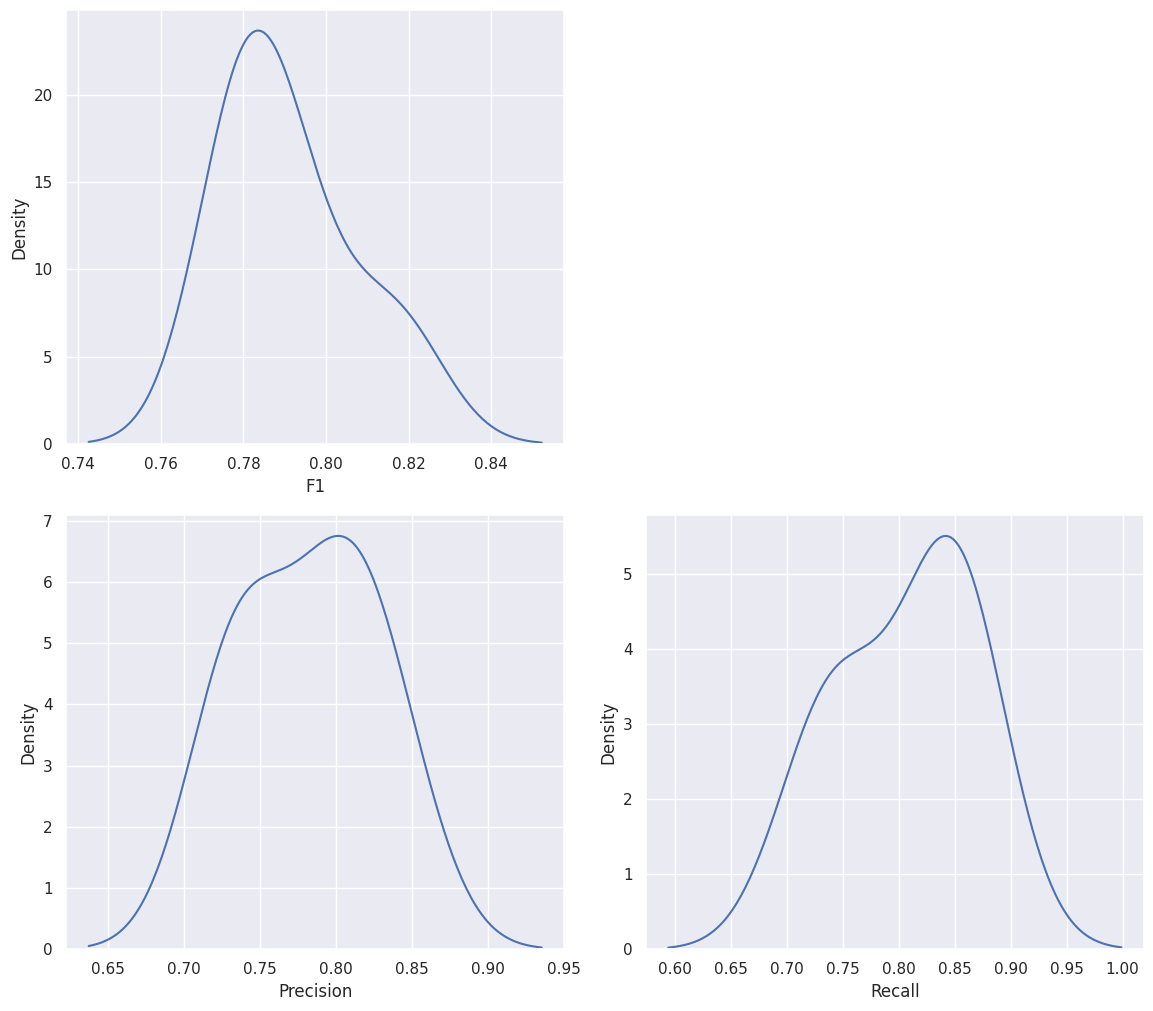

In [70]:
sns.set_theme(rc={'figure.figsize':(11.7, 10.27)})

f, axes = plt.subplots(2, 2)
sns.kdeplot(data=bio_df, x="eval/event_f1", ax=axes[0][0])
axes[0][1].remove()  # Remove the empty second subplot in the first row
sns.kdeplot(data=bio_df, x="eval/event_precision", ax=axes[1][0])
sns.kdeplot(data=bio_df, x="eval/event_recall", ax=axes[1][1])

# Rename x-axis for the last two plots
axes[0][0].set_xlabel("F1")
axes[1][0].set_xlabel("Precision")
axes[1][1].set_xlabel("Recall")

# Adjust layout to prevent overlap
plt.tight_layout()

f.savefig("../results/bio_metric_distribution_events.png", dpi=300)  # Save with high resolution

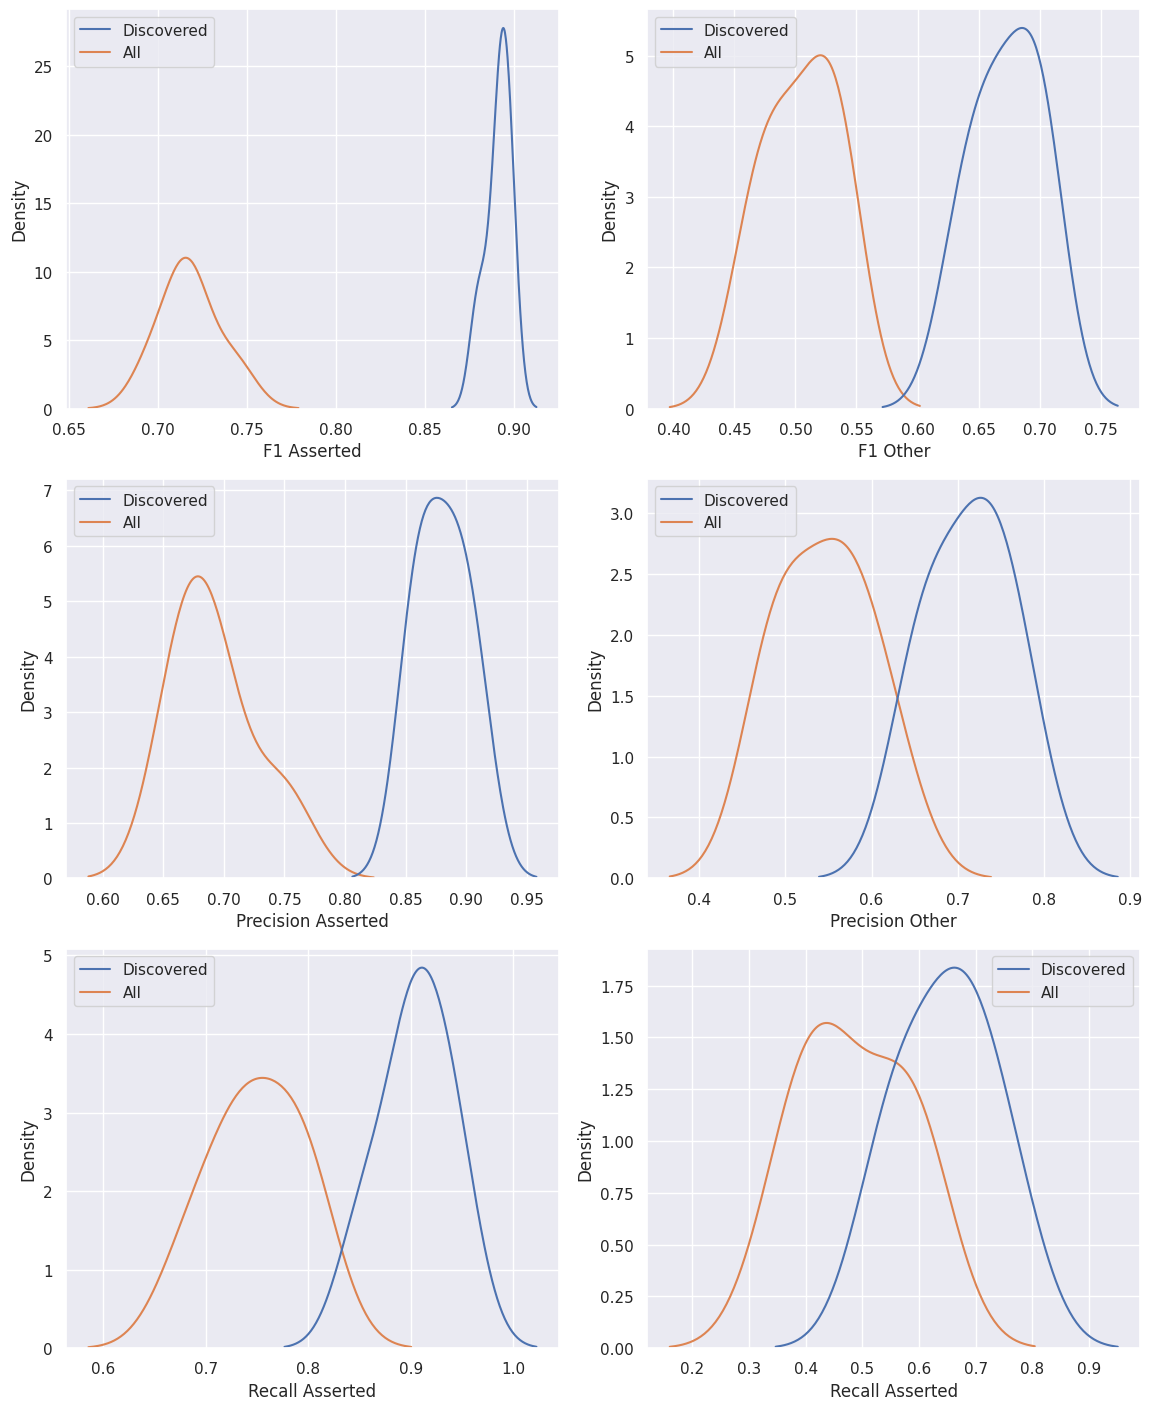

In [89]:
sns.set_theme(rc={'figure.figsize':(11.7, 14.27)})

f, axes = plt.subplots(3, 2)
sns.kdeplot({"Discovered": bio_df['eval/discovered_asserted_f1'], 
             "All": bio_df['eval/all_asserted_f1'],},
            ax=axes[0][0])
sns.kdeplot({"Discovered": bio_df['eval/discovered_other_f1'], 
             "All": bio_df['eval/all_other_f1'],},
           ax=axes[0][1])

sns.kdeplot({"Discovered": bio_df['eval/discovered_asserted_precision'], 
             "All": bio_df['eval/all_asserted_precision'],
            },  ax=axes[1][0])

sns.kdeplot({"Discovered": bio_df['eval/discovered_other_precision'],
             "All": bio_df['eval/all_other_precision']
            },  ax=axes[1][1])

sns.kdeplot({"Discovered": bio_df['eval/discovered_asserted_recall'],
             "All": bio_df['eval/all_asserted_recall'],
            },
            ax=axes[2][0])
sns.kdeplot({"Discovered": bio_df['eval/discovered_other_recall'],
            "All": bio_df['eval/all_other_recall']
            },
            ax=axes[2][1])

axes[0][0].set_xlabel("F1 Asserted")
axes[0][1].set_xlabel("F1 Other")
axes[1][0].set_xlabel("Precision Asserted")
axes[1][1].set_xlabel("Precision Other")
axes[2][0].set_xlabel("Recall Asserted")
axes[2][1].set_xlabel("Recall Asserted")

# Adjust layout to prevent overlap
plt.tight_layout()

f.savefig("../results/bio_metric_distribution_factuality.png", dpi=300)